In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Simple EDA

In [167]:

# Get the list of files in the data directory
data_files = os.listdir('../data')
print("Files in the data directory:", data_files)

# Load the used car dataset
file_path = '../data/used-cars_2cities_prep.csv'

Files in the data directory: ['used-cars_2cities_prep.csv']


In [168]:
cars = pd.read_csv(file_path)
cars.head()

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.6236,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.3702,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,NaN,gas,3.5721,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.3152,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.7000,red,...,0,850,6.745236,1993,25,2.928523,0,0,0,0


In [169]:
cars.drop(columns=["pricestr", "lnprice", "lnodometer", "year", "name"], inplace=True)

cars["subarea"] = cars["subarea"].fillna("Missing")
cars["condition"] = cars["condition"].fillna("Missing")
cars["cylinders"] = cars["cylinders"].fillna("Missing")
cars["drive"] = cars["drive"].fillna("Missing")
cars["fuel"] = cars["fuel"].fillna("Missing")
cars["paintcolor"] = cars["paintcolor"].fillna("Missing")
cars["transmission"] = cars["transmission"].fillna("Missing")
cars["size"] = cars["size"].fillna("Missing")
cars["type"] = cars["type"].fillna("Missing")


In [170]:
cars.isnull().sum()

area              0
subarea           9
condition       222
cylinders       189
drive           255
fuel              1
odometer          0
paintcolor      233
size            356
transmission      0
type            248
dealer            0
price             0
age               0
LE                0
XLE               0
SE                0
Hybrid            0
dtype: int64

In [171]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          549 non-null    object 
 1   subarea       540 non-null    object 
 2   condition     327 non-null    object 
 3   cylinders     360 non-null    object 
 4   drive         294 non-null    object 
 5   fuel          548 non-null    object 
 6   odometer      549 non-null    float64
 7   paintcolor    316 non-null    object 
 8   size          193 non-null    object 
 9   transmission  549 non-null    object 
 10  type          301 non-null    object 
 11  dealer        549 non-null    int64  
 12  price         549 non-null    int64  
 13  age           549 non-null    int64  
 14  LE            549 non-null    int64  
 15  XLE           549 non-null    int64  
 16  SE            549 non-null    int64  
 17  Hybrid        549 non-null    int64  
dtypes: float64(1), int64(7), objec

In [172]:
categorical_columns = ['area', 'subarea', 'condition', 'cylinders', 'drive', 
                      'fuel', 'paintcolor', 'size', 'transmission', 'type']

# Create dummy variables for all categorical columns
cars_encoded = pd.get_dummies(cars, columns=categorical_columns, drop_first=True)

# Display the first few rows of the encoded dataframe
print("Shape before encoding:", cars.shape)
print("Shape after encoding:", cars_encoded.shape)



Shape before encoding: (549, 18)
Shape after encoding: (549, 52)


In [173]:
cars_encoded["dealer"] = cars_encoded["dealer"].astype(bool)
cars_encoded["LE"] = cars_encoded["LE"].astype(bool)
cars_encoded["XLE"] = cars_encoded["XLE"].astype(bool)
cars_encoded["SE"] = cars_encoded["SE"].astype(bool)
cars_encoded["Hybrid"] = cars_encoded["Hybrid"].astype(bool)


In [174]:
cars_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   odometer                      549 non-null    float64
 1   dealer                        549 non-null    bool   
 2   price                         549 non-null    int64  
 3   age                           549 non-null    int64  
 4   LE                            549 non-null    bool   
 5   XLE                           549 non-null    bool   
 6   SE                            549 non-null    bool   
 7   Hybrid                        549 non-null    bool   
 8   area_los angeles              549 non-null    bool   
 9   subarea_LA san gabriel        549 non-null    bool   
 10  subarea_LA westside-southbay  549 non-null    bool   
 11  subarea_North LA county       549 non-null    bool   
 12  subarea_San Fernando          549 non-null    bool   
 13  subar

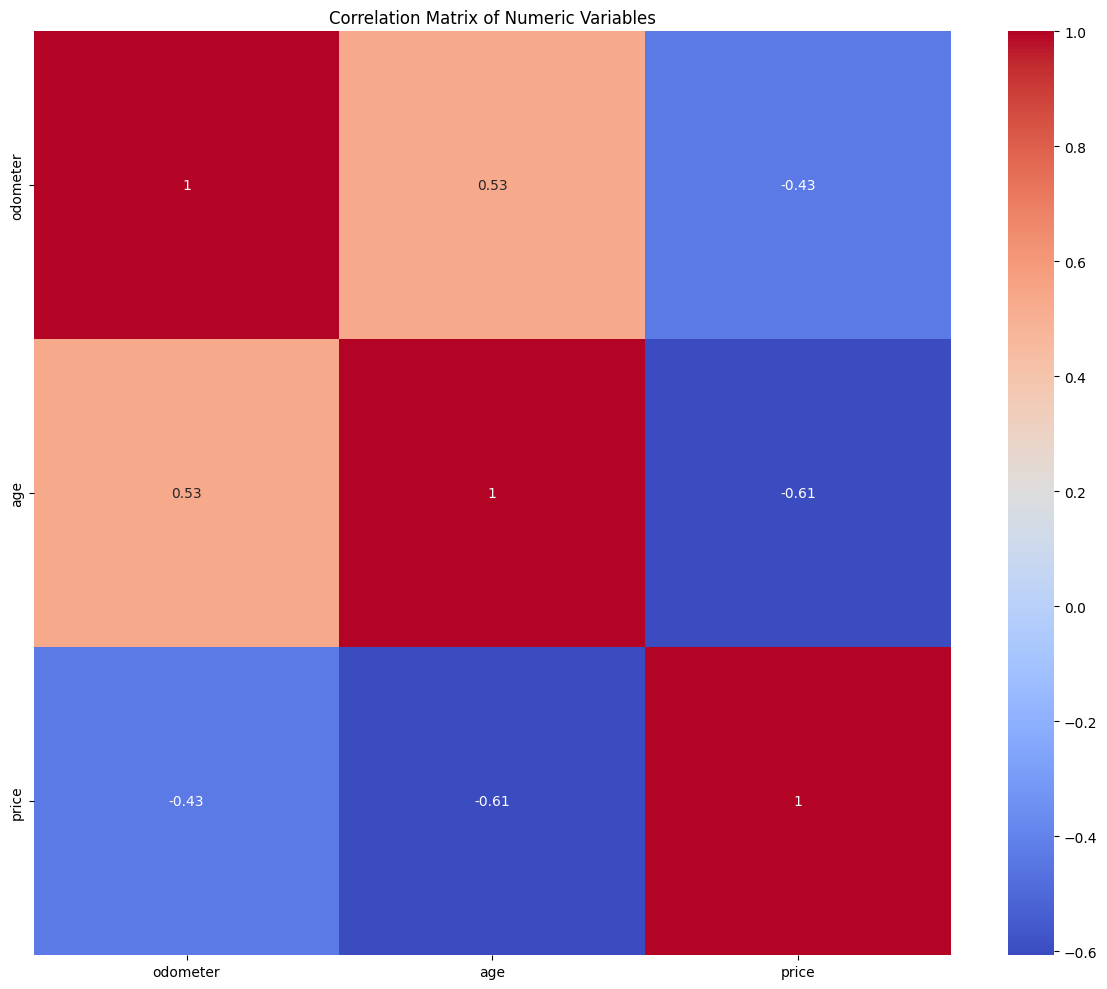

In [176]:
# Define numeric columns first
numeric_columns = ['odometer', 'age', 'price']

plt.figure(figsize=(12, 10))
correlation_matrix = cars_encoded[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()


In [148]:
X = cars_encoded.drop(columns = "price")
y = cars_encoded["price"]

In [207]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, shuffle = True
)

## Model Training

### Run 1 (All Features)

In [ ]:
# Fix the SQLite URL format - need three slashes for relative path
mlflow.set_tracking_uri("sqlite:///used_car_pricing_mlflow.db")
mlflow.set_experiment("used_car_pricing")

2025/03/24 03:04:01 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/03/24 03:04:01 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/henryhu1607/Documents/USFCA/Courses/MSDS_603_MLOps/mlops/notebooks/mlruns/1', creation_time=1742810641426, experiment_id='1', last_update_time=1742810641426, lifecycle_stage='active', name='used_car_pricing', tags={}>

In [159]:
def objective(params):
    with mlflow.start_run(run_name=f"model_full_features_{params}"):
        regressor_type = params['type']
        del params['type']
        if regressor_type == 'dt':
            model = DecisionTreeRegressor(**params)
        elif regressor_type == "rf":
            model = RandomForestRegressor(**params)
        elif regressor_type == "linear":
            model = LinearRegression(**params)

        RMSE = np.sqrt(-cross_val_score(
            model, X_train, y_train, 
            scoring='neg_mean_squared_error', 
            cv=5).mean()
        )

        mlflow.set_tag("Model", regressor_type)
        mlflow.log_params(params)
        mlflow.log_metric("RMSE", RMSE)
        mlflow.sklearn.log_model(model, artifact_path="model")
        # mlflow.end_run()

    return {'loss': RMSE, 'status': STATUS_OK}

In [160]:
searched_space = hp.choice('regressor_type', [
    {
        'type': 'dt',
        'criterion': hp.choice(
            'dtree_criterion', ['squared_error', 'absolute_error']
        ),
        'max_depth': hp.choice(
            'dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1, 10)]
        ),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2, 10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 100),
        'max_features': hp.choice('rf_max_features', ['sqrt', 'log2', None]),
        'criterion': hp.choice(
            'rf_criterion', ['squared_error', 'absolute_error']
        )
    },
    {
        'type': 'linear',
        'fit_intercept': hp.choice('fit_intercept', [True]),
        'positive': hp.choice('positive', [False])
    }
])

In [162]:
mlflow.end_run()

In [177]:
algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn=objective, 
        space=searched_space,
        algo=algo,
        max_evals=80,
        trials=trials
)

  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

2025/03/24 04:11:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  1%|▏         | 1/80 [00:01<01:32,  1.17s/trial, best loss: 5111.273829549102]

2025/03/24 04:11:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  2%|▎         | 2/80 [00:02<01:51,  1.43s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  4%|▍         | 3/80 [00:03<01:33,  1.22s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  5%|▌         | 4/80 [00:04<01:21,  1.07s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  6%|▋         | 5/80 [00:06<01:40,  1.34s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  8%|▊         | 6/80 [00:07<01:32,  1.26s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  9%|▉         | 7/80 [00:08<01:22,  1.13s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 10%|█         | 8/80 [00:09<01:24,  1.18s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 11%|█▏        | 9/80 [00:10<01:17,  1.09s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 12%|█▎        | 10/80 [00:11<01:20,  1.14s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 14%|█▍        | 11/80 [00:12<01:13,  1.07s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 15%|█▌        | 12/80 [00:13<01:14,  1.10s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 16%|█▋        | 13/80 [00:14<01:08,  1.02s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 18%|█▊        | 14/80 [00:15<01:04,  1.02trial/s, best loss: 4849.970581155038]

2025/03/24 04:11:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 19%|█▉        | 15/80 [00:16<01:01,  1.07trial/s, best loss: 4849.970581155038]

2025/03/24 04:11:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 20%|██        | 16/80 [00:17<01:04,  1.01s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 21%|██▏       | 17/80 [00:19<01:12,  1.15s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 22%|██▎       | 18/80 [00:20<01:15,  1.22s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 24%|██▍       | 19/80 [00:21<01:17,  1.27s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 25%|██▌       | 20/80 [00:22<01:07,  1.13s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 26%|██▋       | 21/80 [00:23<01:08,  1.16s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 28%|██▊       | 22/80 [00:25<01:15,  1.31s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 29%|██▉       | 23/80 [00:26<01:09,  1.21s/trial, best loss: 4849.970581155038]

2025/03/24 04:11:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 30%|███       | 24/80 [00:27<01:11,  1.28s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 31%|███▏      | 25/80 [00:29<01:15,  1.37s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 32%|███▎      | 26/80 [00:30<01:10,  1.31s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 34%|███▍      | 27/80 [00:31<01:02,  1.18s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 35%|███▌      | 28/80 [00:33<01:05,  1.25s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 36%|███▋      | 29/80 [00:34<01:06,  1.31s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 38%|███▊      | 30/80 [00:35<01:05,  1.30s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 39%|███▉      | 31/80 [00:37<01:07,  1.38s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 40%|████      | 32/80 [00:38<01:00,  1.26s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 41%|████▏     | 33/80 [00:39<00:54,  1.17s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 42%|████▎     | 34/80 [00:40<00:49,  1.08s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 44%|████▍     | 35/80 [00:41<00:53,  1.19s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 45%|████▌     | 36/80 [00:42<00:49,  1.13s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 46%|████▋     | 37/80 [00:43<00:48,  1.14s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 48%|████▊     | 38/80 [00:44<00:47,  1.14s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 49%|████▉     | 39/80 [00:45<00:43,  1.05s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 40/80 [00:46<00:44,  1.10s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 51%|█████▏    | 41/80 [00:48<00:43,  1.12s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 52%|█████▎    | 42/80 [00:49<00:40,  1.06s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 54%|█████▍    | 43/80 [00:49<00:36,  1.00trial/s, best loss: 4815.386259118965]

2025/03/24 04:12:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 55%|█████▌    | 44/80 [00:52<00:53,  1.48s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 56%|█████▋    | 45/80 [00:54<00:53,  1.53s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 57%|█████▊    | 46/80 [00:55<00:52,  1.55s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 59%|█████▉    | 47/80 [00:56<00:44,  1.34s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 60%|██████    | 48/80 [00:57<00:38,  1.21s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 61%|██████▏   | 49/80 [00:58<00:34,  1.12s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 62%|██████▎   | 50/80 [01:02<00:59,  2.00s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 64%|██████▍   | 51/80 [01:03<00:48,  1.66s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 65%|██████▌   | 52/80 [01:04<00:46,  1.68s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 66%|██████▋   | 53/80 [01:05<00:38,  1.43s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 68%|██████▊   | 54/80 [01:06<00:34,  1.33s/trial, best loss: 4815.386259118965]

2025/03/24 04:12:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 69%|██████▉   | 55/80 [01:08<00:33,  1.35s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 70%|███████   | 56/80 [01:09<00:28,  1.19s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 71%|███████▏  | 57/80 [01:10<00:25,  1.10s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 72%|███████▎  | 58/80 [01:13<00:38,  1.75s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 74%|███████▍  | 59/80 [01:14<00:31,  1.50s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 75%|███████▌  | 60/80 [01:15<00:30,  1.52s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 76%|███████▋  | 61/80 [01:16<00:26,  1.41s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 78%|███████▊  | 62/80 [01:17<00:22,  1.24s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 79%|███████▉  | 63/80 [01:20<00:26,  1.57s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 80%|████████  | 64/80 [01:21<00:22,  1.39s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 81%|████████▏ | 65/80 [01:22<00:19,  1.30s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 82%|████████▎ | 66/80 [01:23<00:18,  1.32s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 84%|████████▍ | 67/80 [01:24<00:17,  1.31s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 85%|████████▌ | 68/80 [01:26<00:15,  1.32s/trial, best loss: 4800.617537717432]

2025/03/24 04:12:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 86%|████████▋ | 69/80 [01:27<00:14,  1.34s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 88%|████████▊ | 70/80 [01:29<00:13,  1.37s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 89%|████████▉ | 71/80 [01:30<00:11,  1.33s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 90%|█████████ | 72/80 [01:31<00:10,  1.35s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 91%|█████████▏| 73/80 [01:32<00:08,  1.28s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 92%|█████████▎| 74/80 [01:34<00:08,  1.35s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 94%|█████████▍| 75/80 [01:35<00:06,  1.27s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 95%|█████████▌| 76/80 [01:36<00:04,  1.21s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 96%|█████████▋| 77/80 [01:37<00:03,  1.12s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 98%|█████████▊| 78/80 [01:38<00:02,  1.12s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 99%|█████████▉| 79/80 [01:39<00:01,  1.05s/trial, best loss: 4800.617537717432]

2025/03/24 04:13:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 80/80 [01:40<00:00,  1.26s/trial, best loss: 4800.617537717432]


## Run 2 (Selected Features)

In [208]:
# Calculate correlation between features and price
correlation_with_price = pd.DataFrame(cars_encoded.corrwith(cars_encoded['price']), columns=['correlation'])
correlation_with_price["correlation"] = correlation_with_price["correlation"].abs()
correlation_with_price.sort_values(by="correlation", ascending=False)
drop_features = correlation_with_price.iloc[-20:,:].index.tolist()

In [209]:
X_train.drop(columns=drop_features, inplace=True)
X_test.drop(columns=drop_features, inplace=True)
X_train.shape, X_test.shape


((439, 31), (110, 31))

In [213]:
def objective_2(params):
    with mlflow.start_run(run_name=f"model_selected_features_{params}"):
        regressor_type = params['type']
        del params['type']
        if regressor_type == 'dt':
            model = DecisionTreeRegressor(**params)
        elif regressor_type == "rf":
            model = RandomForestRegressor(**params)
        elif regressor_type == "linear":
            model = LinearRegression(**params)

        RMSE = np.sqrt(-cross_val_score(
            model, X_train, y_train, 
            scoring='neg_mean_squared_error', 
            cv=5).mean()
        )

        mlflow.set_tag("Model", regressor_type)
        mlflow.log_params(params)
        mlflow.log_metric("RMSE", RMSE)
        mlflow.sklearn.log_model(model, artifact_path="model")
        # mlflow.end_run()

    return {'loss': RMSE, 'status': STATUS_OK}

In [214]:
searched_space_2 = hp.choice('regressor_type', [
    {
        'type': 'dt',
        'criterion': hp.choice(
            'dtree_criterion', ['squared_error', 'absolute_error']
        ),
        'max_depth': hp.choice(
            'dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1, 10)]
        ),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2, 10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 100),
        'max_features': hp.choice('rf_max_features', ['sqrt', 'log2', None]),
        'criterion': hp.choice(
            'rf_criterion', ['squared_error', 'absolute_error']
        )
    },
    {
        'type': 'linear',
        'fit_intercept': hp.choice('fit_intercept', [True]),
        'positive': hp.choice('positive', [False])
    }
])

In [212]:
mlflow.end_run()

In [215]:
algo = tpe.suggest
trials = Trials()
best_result_2 = fmin(
        fn=objective_2, 
        space=searched_space_2,
        algo=algo,
        max_evals=80,
        trials=trials
)

  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

2025/03/24 22:38:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  1%|▏         | 1/80 [00:01<02:05,  1.58s/trial, best loss: 5348.291095332535]

2025/03/24 22:38:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  2%|▎         | 2/80 [00:02<01:31,  1.18s/trial, best loss: 5166.1280322239845]

2025/03/24 22:38:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  4%|▍         | 3/80 [00:03<01:26,  1.12s/trial, best loss: 4953.415957995582] 

2025/03/24 22:38:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  5%|▌         | 4/80 [00:04<01:27,  1.15s/trial, best loss: 4953.415957995582]

2025/03/24 22:38:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  6%|▋         | 5/80 [00:05<01:18,  1.05s/trial, best loss: 4855.94856559948] 

2025/03/24 22:38:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  8%|▊         | 6/80 [00:06<01:12,  1.02trial/s, best loss: 4855.94856559948]

2025/03/24 22:38:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  9%|▉         | 7/80 [00:07<01:21,  1.11s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 10%|█         | 8/80 [00:08<01:12,  1.01s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 11%|█▏        | 9/80 [00:09<01:12,  1.02s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 12%|█▎        | 10/80 [00:10<01:12,  1.03s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 14%|█▍        | 11/80 [00:12<01:17,  1.12s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 15%|█▌        | 12/80 [00:12<01:09,  1.03s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 16%|█▋        | 13/80 [00:13<01:06,  1.01trial/s, best loss: 4855.94856559948]

2025/03/24 22:38:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 18%|█▊        | 14/80 [00:16<01:38,  1.49s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 19%|█▉        | 15/80 [00:17<01:30,  1.39s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 20%|██        | 16/80 [00:18<01:21,  1.28s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 21%|██▏       | 17/80 [00:21<01:56,  1.85s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 22%|██▎       | 18/80 [00:22<01:38,  1.59s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 24%|██▍       | 19/80 [00:23<01:27,  1.43s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 25%|██▌       | 20/80 [00:24<01:15,  1.25s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 26%|██▋       | 21/80 [00:25<01:07,  1.15s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 28%|██▊       | 22/80 [00:26<01:06,  1.15s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 29%|██▉       | 23/80 [00:27<01:03,  1.12s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 30%|███       | 24/80 [00:28<01:00,  1.08s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 31%|███▏      | 25/80 [00:29<00:57,  1.05s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 32%|███▎      | 26/80 [00:30<00:54,  1.02s/trial, best loss: 4855.94856559948]

2025/03/24 22:38:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 34%|███▍      | 27/80 [00:31<00:52,  1.01trial/s, best loss: 4719.9998958105025]

2025/03/24 22:38:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 35%|███▌      | 28/80 [00:32<00:50,  1.04trial/s, best loss: 4719.9998958105025]

2025/03/24 22:38:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 36%|███▋      | 29/80 [00:33<00:48,  1.05trial/s, best loss: 4719.9998958105025]

2025/03/24 22:38:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 38%|███▊      | 30/80 [00:34<00:47,  1.04trial/s, best loss: 4719.9998958105025]

2025/03/24 22:38:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 39%|███▉      | 31/80 [00:35<00:48,  1.01trial/s, best loss: 4719.9998958105025]

2025/03/24 22:38:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 40%|████      | 32/80 [00:36<00:46,  1.03trial/s, best loss: 4719.9998958105025]

2025/03/24 22:38:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 41%|████▏     | 33/80 [00:37<00:52,  1.11s/trial, best loss: 4719.9998958105025]

2025/03/24 22:38:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 42%|████▎     | 34/80 [00:38<00:49,  1.08s/trial, best loss: 4719.9998958105025]

2025/03/24 22:38:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 44%|████▍     | 35/80 [00:39<00:46,  1.03s/trial, best loss: 4719.9998958105025]

2025/03/24 22:39:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 45%|████▌     | 36/80 [00:40<00:44,  1.01s/trial, best loss: 4708.922639030734] 

2025/03/24 22:39:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 46%|████▋     | 37/80 [00:41<00:42,  1.02trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 48%|████▊     | 38/80 [00:42<00:40,  1.04trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 49%|████▉     | 39/80 [00:43<00:39,  1.03trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 40/80 [00:44<00:39,  1.02trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 51%|█████▏    | 41/80 [00:45<00:36,  1.05trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 52%|█████▎    | 42/80 [00:46<00:35,  1.07trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 54%|█████▍    | 43/80 [00:47<00:35,  1.06trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 55%|█████▌    | 44/80 [00:48<00:38,  1.07s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 56%|█████▋    | 45/80 [00:49<00:37,  1.07s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 57%|█████▊    | 46/80 [00:50<00:34,  1.02s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 59%|█████▉    | 47/80 [00:51<00:36,  1.10s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 60%|██████    | 48/80 [00:52<00:33,  1.05s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 61%|██████▏   | 49/80 [00:53<00:31,  1.01s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 62%|██████▎   | 50/80 [00:54<00:30,  1.00s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 64%|██████▍   | 51/80 [00:55<00:28,  1.01trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 65%|██████▌   | 52/80 [00:56<00:27,  1.02trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 66%|██████▋   | 53/80 [00:57<00:25,  1.06trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 68%|██████▊   | 54/80 [00:58<00:25,  1.02trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 69%|██████▉   | 55/80 [00:59<00:23,  1.07trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 70%|███████   | 56/80 [01:00<00:22,  1.08trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 71%|███████▏  | 57/80 [01:01<00:20,  1.10trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 72%|███████▎  | 58/80 [01:04<00:33,  1.54s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 74%|███████▍  | 59/80 [01:05<00:28,  1.35s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 75%|███████▌  | 60/80 [01:05<00:23,  1.19s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 76%|███████▋  | 61/80 [01:06<00:20,  1.08s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 78%|███████▊  | 62/80 [01:07<00:18,  1.04s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 79%|███████▉  | 63/80 [01:08<00:19,  1.13s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 80%|████████  | 64/80 [01:10<00:18,  1.16s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 81%|████████▏ | 65/80 [01:11<00:16,  1.08s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 82%|████████▎ | 66/80 [01:11<00:14,  1.01s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 84%|████████▍ | 67/80 [01:12<00:12,  1.02trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 85%|████████▌ | 68/80 [01:13<00:11,  1.04trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 86%|████████▋ | 69/80 [01:14<00:10,  1.04trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 88%|████████▊ | 70/80 [01:15<00:09,  1.03trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 89%|████████▉ | 71/80 [01:16<00:09,  1.00s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 90%|█████████ | 72/80 [01:17<00:08,  1.01s/trial, best loss: 4708.922639030734]

2025/03/24 22:39:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 91%|█████████▏| 73/80 [01:18<00:06,  1.01trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 92%|█████████▎| 74/80 [01:19<00:05,  1.03trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 94%|█████████▍| 75/80 [01:20<00:04,  1.06trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 95%|█████████▌| 76/80 [01:21<00:03,  1.09trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 96%|█████████▋| 77/80 [01:22<00:02,  1.10trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 98%|█████████▊| 78/80 [01:23<00:01,  1.07trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 99%|█████████▉| 79/80 [01:24<00:00,  1.05trial/s, best loss: 4708.922639030734]

2025/03/24 22:39:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 80/80 [01:25<00:00,  1.06s/trial, best loss: 4708.922639030734]


## Logging 3 best models across 2 runs

In [220]:
best_runs = ["3ca1a61100ba4e5bafe97f1c78b0fe89", "95edbd307bd941eda74eb3299a5cd8b5","0afe945afc78414892f28d0f8871ae43"]

In [218]:
os.makedirs("used_car_saved_data", exist_ok=True)
X_train.to_parquet("used_car_saved_data/X_train.parquet")
X_test.to_parquet("used_car_saved_data/X_test.parquet")
pd.DataFrame(y_train).to_parquet("used_car_saved_data/y_train.parquet")
pd.DataFrame(y_test).to_parquet("used_car_saved_data/y_test.parquet")

In [ ]:
for run_id in best_runs:
    with mlflow.start_run(run_id = run_id):
        mlflow.log_artifact("used_car_saved_data/")

## Register the best model and run it with test metrics

In [230]:
runid = "3ca1a61100ba4e5bafe97f1c78b0fe89"
mod_path = f'runs:/{runid}/artifacts/model'
mlflow.register_model(model_uri = mod_path, name = 'best_used_car_model_prediction_3/24/2025')

Successfully registered model 'best_used_car_model_prediction_3/24/2025'.
Created version '1' of model 'best_used_car_model_prediction_3/24/2025'.


<ModelVersion: aliases=[], creation_timestamp=1742883053213, current_stage='None', description=None, last_updated_timestamp=1742883053213, name='best_used_car_model_prediction_3/24/2025', run_id='3ca1a61100ba4e5bafe97f1c78b0fe89', run_link=None, source='/Users/henryhu1607/Documents/USFCA/Courses/MSDS_603_MLOps/mlops/notebooks/mlruns/1/3ca1a61100ba4e5bafe97f1c78b0fe89/artifacts/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [223]:
logged_model = 'runs:/3ca1a61100ba4e5bafe97f1c78b0fe89/model'

loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.sklearn
  run_id: 3ca1a61100ba4e5bafe97f1c78b0fe89

In [227]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

DecisionTreeRegressor(criterion='absolute_error', max_depth=3)

In [ ]:
with mlflow.start_run(run_name=f"best_model_test_run"):
    model = sklearn_model

    RMSE = np.sqrt(-cross_val_score(
        model, X_train, y_train, 
        scoring='neg_mean_squared_error', 
        cv=5).mean()
    )
    model.fit(X_train, y_train)
    test_RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

    mlflow.set_tag("Model", "dt")
    mlflow.log_params({
        "criterion": "absolute_error",
        "max_depth": 3,
        "min_samples_split": 2
    })
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("Test RMSE", test_RMSE)
    mlflow.log_artifact("used_car_saved_data/")
    mlflow.sklearn.log_model(model, artifact_path="model")
    # mlflow.end_run()

2025/03/24 23:17:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
